# (t, n) Sharing Scheme

## Finding inverse of a general (Ax + b) mod N 

In [1]:
import numpy as np

# Defining the randomizer equation as A(x + b) mod N
def randomizer(x, A, b, c, d, i, j, N):
    x = np.int64(x) 
    A = np.int64(A)
    b = np.int64(b)
    c = np.int64(c)
    d = np.int64(d)
    i = np.int64(i)
    j = np.int64(j)
    N = np.int64(N)
    return (A * (x + b + c * i + d * i + i * j)) % N

# the equation is of the form A(x + b + c*i + d*i + i*j) mod N

# Finding the inverse of the randomizer equation as A^-1*x - b mod N
def inverse_randomizer(y, A_inv, b, c, d, i, j, N):
    y = np.int64(y)
    A_inv = np.int64(A_inv)
    b = np.int64(b)
    c = np.int64(c)
    d = np.int64(d)
    i = np.int64(i)
    j = np.int64(j)
    N = np.int64(N)
    return ((A_inv * y) - b - c * i - d * i - i * j) % N

def modinv(a, n):
    a = np.int64(a)
    n = np.int64(n)
    t, new_t = np.int64(0), np.int64(1)
    r, new_r = n, a
    while new_r != 0:
        quotient = r // new_r
        t, new_t = new_t, t - quotient * new_t
        r, new_r = new_r, r - quotient * new_r
    if r > 1:
        return None  # no inverse exists
    return t % n

### Exaple Usage of this randomizer function along with its inverse

In [3]:
# Example
A = 203
b = 15
c = 153
d = 203
i = 2
j = 3
N = 256
A_inv = modinv(A, N)
if A_inv is None:
    raise ValueError("Inverse does not exist")

# Original pixel value
x = 102

# Randomized pixel value
y = randomizer(x, A, b, c, d, i, j, N)

print(f"Original pixel value: {x}")
print(f"Randomized pixel value: {y}")

# Inverse randomized pixel value
x_inv = inverse_randomizer(y, A_inv, b, c, d, i, j, N)
print(f"Inverse randomized pixel value: {x_inv}")



# run from x = 0 to 255 and check if the inverse is correct
for x in range(256):
    y = randomizer(x, A, b, c, d, i, j, N)
    x_inv = inverse_randomizer(y, A_inv, b, c, d, i, j, N)
    if x != x_inv:
        print(f"Mismatch for x={x}: randomized={y}, inverse={x_inv}")
        break
else:
    print("All values match!, the randomizer and inverse are one to one")

Original pixel value: 102
Randomized pixel value: 33
Inverse randomized pixel value: 102
All values match!, the randomizer and inverse are one to one


## Encrypting an Image using this function

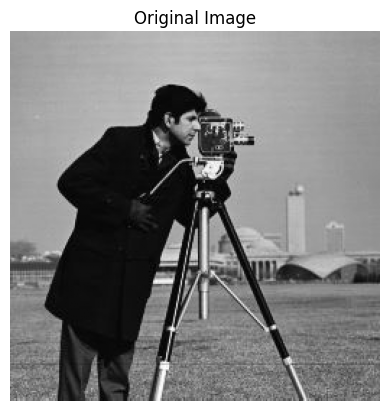

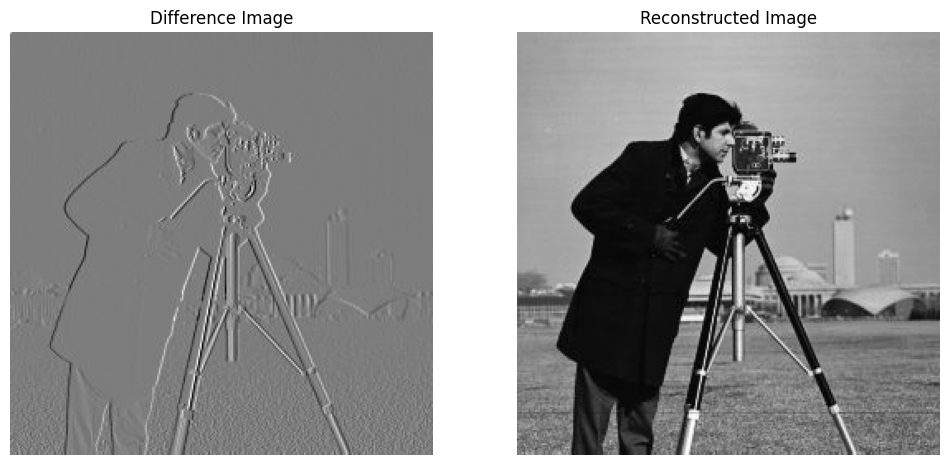

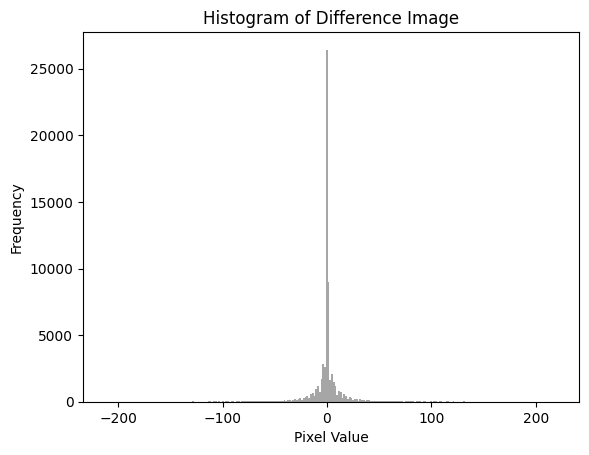

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import measure


# Load the original image in grayscale
image = Image.open('cover_image.jpg')
image = image.convert('L')
image = np.array(image).astype(np.int64)

# Plotting original image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

# Difference Matrix Calculation
def calculate_diff_matrix(img, init_i=0, init_j=0):
  rows, cols = img.shape
  diff_matrix = np.zeros_like(img, dtype=np.int64)  # Initialize with zeros

  # from init_i, init_j to the end of the image
  for i in range(init_i, rows):
    for j in range(init_j, cols):
      if i == 0 and j == 0:
        diff_matrix[i, j] = img[i, j]
      elif i != 0 and j == 0:
        diff_matrix[i, j] = img[i, j] - img[i - 1, j]
      else:
        diff_matrix[i, j] = img[i, j] - img[i, j - 1]

  return diff_matrix


def inverse_difference(diff_matrix, init_i=0, init_j=0):
    rows, cols = diff_matrix.shape
    reconstructed = np.zeros_like(diff_matrix, dtype=np.int64)  # Initialize with zeros

    # from init_i, init_j to the end of the image
    for i in range(init_i, rows):
        for j in range(init_j, cols):
            if i == 0 and j == 0:
                reconstructed[i, j] = diff_matrix[i, j]
            elif i != 0 and j == 0:
                reconstructed[i, j] = diff_matrix[i, j] + reconstructed[i - 1, j]
            else:
                reconstructed[i, j] = diff_matrix[i, j] + reconstructed[i, j - 1]

    return reconstructed

diff_img = calculate_diff_matrix(image)
reconstructed_img = inverse_difference(diff_img)

# plot both 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(diff_img, cmap='gray')
plt.axis('off')
plt.title('Difference Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.axis('off')
plt.title('Reconstructed Image')
plt.show()

# plot histogram for diff_img
plt.hist(diff_img.ravel(), bins=256, color='gray', alpha=0.7)
plt.title('Histogram of Difference Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


In [14]:
from collections import defaultdict
# --- Dynamic Huffman Coding ---
def dynamic_huffman(pixels):
    frequencies = defaultdict(int)
    for pixel in pixels:
        frequencies[pixel] += 1

    # Simplified Huffman coding 
    sorted_frequencies = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)
    codes = {pixel: bin(i)[2:] for i, (pixel, _) in enumerate(sorted_frequencies)}

    return codes

In [15]:
# Flatten the difference image array
flat_diff_pixels = diff_img.flatten()

# Apply dynamic Huffman coding to the difference image
huffman_codes_diff = dynamic_huffman(flat_diff_pixels)

# Print the Huffman codes for the difference image
print("Huffman Codes for Difference Image:") # only top 10
for pixel, code in list(huffman_codes_diff.items())[:10]:
    print(f"Pixel: {pixel}, Code: {code}")

Huffman Codes for Difference Image:
Pixel: 0, Code: 0
Pixel: -1, Code: 1
Pixel: 1, Code: 10
Pixel: -2, Code: 11
Pixel: 2, Code: 100
Pixel: -3, Code: 101
Pixel: 3, Code: 110
Pixel: -4, Code: 111
Pixel: 4, Code: 1000
Pixel: 5, Code: 1001


1001100000000000101010010001111011001010101110101001010111101010101000101110010010101000000001000001


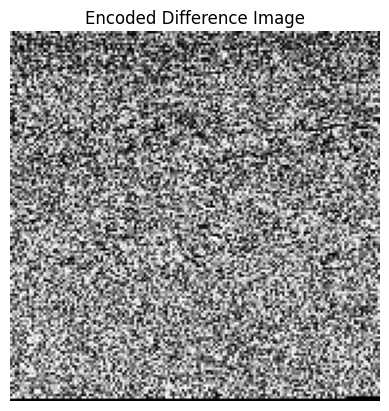

Original Size: 524288 bytes
Encoded Size: 23856.0 bytes
Compression Ratio: 21.98


In [17]:
import math

# Encode the difference image pixels using Huffman codes
encoded_pixels = "".join([huffman_codes_diff[pixel] for pixel in flat_diff_pixels])

print(encoded_pixels[:100])  # Print first 100 bits of the encoded string

# Group encoded bits into bytes (8 bits each)
encoded_bytes = [encoded_pixels[i:i+8] for i in range(0, len(encoded_pixels), 8)]

# Handle the last byte if its length is less than 8
if len(encoded_bytes[-1]) < 8:
    encoded_bytes[-1] = encoded_bytes[-1].ljust(8, '0')  # Pad with zeros

# Convert encoded bytes to integers
encoded_integers = [int(byte, 2) for byte in encoded_bytes]


# Determine new image dimensions
num_encoded_integers = len(encoded_integers)
new_size = int(math.ceil(math.sqrt(num_encoded_integers)))
new_image_shape = (new_size, new_size)

# Create the new image matrix
new_image = np.zeros(new_image_shape, dtype=np.uint64)

# Populate the new image matrix with encoded integers
for i in range(num_encoded_integers):
  row = i // new_size
  col = i % new_size
  if row < new_size and col < new_size:
    new_image[row, col] = encoded_integers[i]


# Display the new image
plt.imshow(new_image, cmap='gray')
plt.title('Encoded Difference Image')
plt.axis('off')
plt.show()


# Size of the original image vs the encoded image in bytes
original_size = image.nbytes
encoded_size = len(encoded_integers) * 8 / 8  # Convert bits to bytes

compression_ratio = original_size / encoded_size
print(f"Original Size: {original_size} bytes")
print(f"Encoded Size: {encoded_size} bytes")
print(f"Compression Ratio: {compression_ratio:.2f}")

Original Image Size: 65536 bytes
Encoded Image Size: 24025 bytes
Original Image Shape: (256, 256)
Encoded Image Shape: (155, 155)


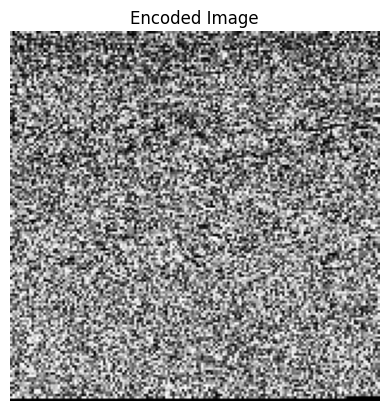

In [18]:
# compare original and encoded image sizes
original_size = image.size
encoded_size = new_image.size
print(f"Original Image Size: {original_size} bytes")
print(f"Encoded Image Size: {encoded_size} bytes")
# shape also
print(f"Original Image Shape: {image.shape}")
print(f"Encoded Image Shape: {new_image.shape}")


# plot new image
plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.title('Encoded Image')
plt.show()


Inverse of A: 227


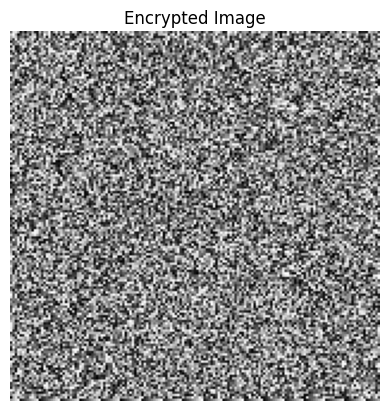

Encrypted Image Size: 192200 bytes
Encrypted Image Shape: (155, 155)


In [19]:
# Encrypting the image using the randomizer equation
A = 203
b = 15
c = 153
d = 203
N = 256
A_inv = modinv(A, N)
print(f"Inverse of A: {A_inv}")
if A_inv is None:
    raise ValueError("Inverse does not exist")

# Encrypt the image using the randomizer equation
encrypted_image = np.zeros_like(new_image, dtype=np.uint64)
for i in range(new_image.shape[0]):
    for j in range(new_image.shape[1]):
        encrypted_image[i, j] = randomizer(new_image[i, j], A, b, c, d, i, j, N)

# Convert back to an image
# encrypted_new_image = Image.fromarray(encrypted_image.astype(np.uint32))

# # Plotting encrypted image
plt.imshow(encrypted_image, cmap='gray')
plt.axis('off')
plt.title('Encrypted Image')
plt.show()

# size and shape of encrypted image
print(f"Encrypted Image Size: {encrypted_image.nbytes} bytes")
print(f"Encrypted Image Shape: {encrypted_image.shape}")


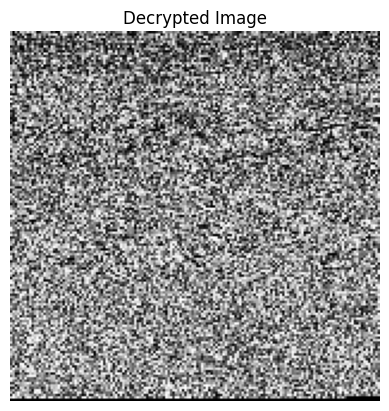

Decrypted Image Size: 192200 bytes
Decrypted Image Shape: (155, 155)


In [21]:
# Quick test to check if the encryption and decryption work
# Decrypt the image using the inverse randomizer equation
decrypted_image = np.zeros_like(encrypted_image, dtype=np.uint64)
for i in range(encrypted_image.shape[0]):
    for j in range(encrypted_image.shape[1]):
        decrypted_image[i, j] = inverse_randomizer(encrypted_image[i, j], A_inv, b, c, d, i, j, N)

# Convert back to an image
# new_image_decrypted = Image.fromarray(decrypted_image.astype(np.uint64))

# Plotting decrypted image
plt.imshow(decrypted_image, cmap='gray')
plt.axis('off')
plt.title('Decrypted Image')
plt.show()

# Size and Shape of decrypted image
print(f"Decrypted Image Size: {decrypted_image.nbytes} bytes")
print(f"Decrypted Image Shape: {decrypted_image.shape}")

PSNR: inf
SSIM: 1.0


d:\Major Proj\(t,n)\myenv\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


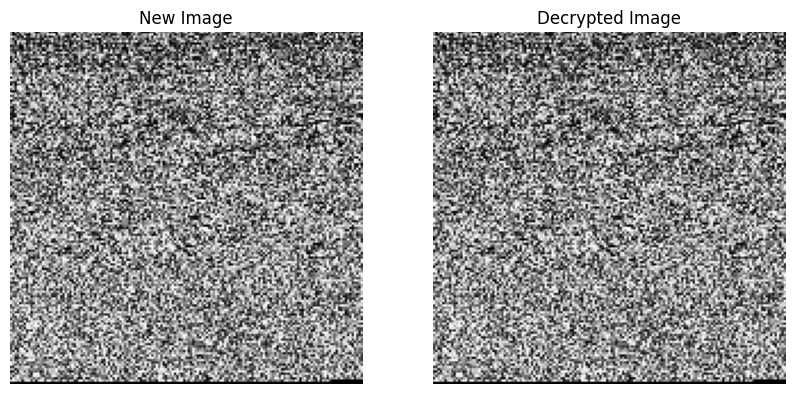

In [22]:
psnr_value = psnr(new_image, decrypted_image)
ssim_value = ssim(new_image, decrypted_image, data_range=decrypted_image.max() - decrypted_image.min())
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")


# plot new image and decrypted image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.title('New Image')
plt.subplot(1, 2, 2)
plt.imshow(decrypted_image, cmap='gray')
plt.axis('off')
plt.title('Decrypted Image')
plt.show()

### Checking recovery from the hoffman encoded image

In [23]:
import heapq
from collections import Counter

class Node:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):  # for priority queue
        return self.freq < other.freq


def build_huffman_tree(freq_table):
    heap = [Node(symbol=symbol, freq=freq) for symbol, freq in freq_table.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(freq=left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)

    return heap[0]


def build_code_map(node):
    code_map = {}

    def _build_code_map_recursive(n, current_code):
        if n is None:
            return
        if n.symbol is not None:
            code_map[n.symbol] = current_code
            return
        _build_code_map_recursive(n.left, current_code + '0')
        _build_code_map_recursive(n.right, current_code + '1')

    _build_code_map_recursive(node, '')
    return code_map


def huffman_decode(encoded_bits, code_map):
    # Reverse map
    reverse_map = {v: k for k, v in code_map.items()}
    decoded = []
    current = ''

    for bit in encoded_bits:
        current += bit
        if current in reverse_map:
            decoded.append(reverse_map[current])
            current = ''

    return decoded


# Example usage
if __name__ == "__main__":
    # Sample data
    pixels = [i % 10 for i in range(100)]  # 0 to 9, repeated

    # Step 1: Frequency table
    freq_table = Counter(pixels)

    # Step 2: Huffman Tree and Codes
    tree = build_huffman_tree(freq_table)
    code_map = build_code_map(tree)

    # Step 3: Encoding
    encoded_bits = ''.join(code_map[p] for p in pixels)

    # Step 4: Decoding
    decoded_pixels = huffman_decode(encoded_bits, code_map)

    print(f"Original Pixels:  {pixels[:20]} ...")
    print(f"Encoded Bits:     {encoded_bits[:50]} ...")
    print(f"Decoded Pixels:   {decoded_pixels[:20]} ...")
    print("✅ Decoding successful?", decoded_pixels == pixels)


Original Pixels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...
Encoded Bits:     11001101011100000101010111000111111100110101110000 ...
Decoded Pixels:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...
✅ Decoding successful? True


In [24]:
from collections import Counter

# Generate frequency table from flat_diff_pixels
freq_table = Counter(flat_diff_pixels)

# Rebuild Huffman tree and code map
tree = build_huffman_tree(freq_table)
code_map = build_code_map(tree)

# Encode flat_diff_pixels using the updated code_map
encoded_bits = ''.join(code_map[pixel] for pixel in flat_diff_pixels)

# Decode the encoded bits back to pixels using Huffman codes
decoded_pixels = huffman_decode(encoded_bits, code_map)

print(f"Encoded Bits: {encoded_bits[:50]} ...")
print(f"Decoded Pixels: {decoded_pixels[:20]} ...")
print("✅ Decoding successful?", decoded_pixels == flat_diff_pixels.tolist())

Encoded Bits: 00000101001110101010101010100010111011011110111001 ...
Decoded Pixels: [np.int64(157), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(-1), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(-1), np.int64(-1), np.int64(3), np.int64(-1), np.int64(-1), np.int64(0)] ...
✅ Decoding successful? True


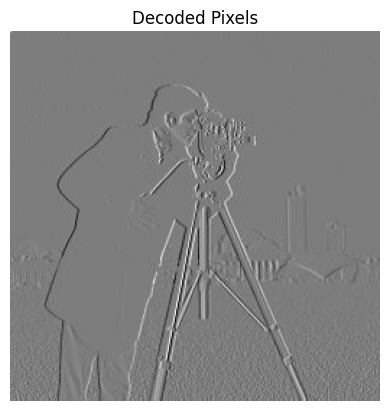

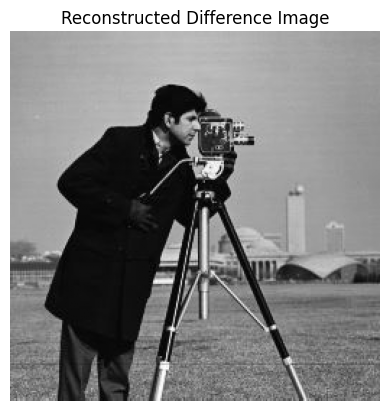

In [25]:
# undoing the difference matrix

# plotting the decoded pixels   
plt.imshow(np.array(decoded_pixels).reshape(image.shape), cmap='gray')
plt.axis('off')
plt.title('Decoded Pixels')
plt.show()


reconstructed_diff_img = inverse_difference(np.array(decoded_pixels).reshape(image.shape))
plt.imshow(reconstructed_diff_img, cmap='gray')
plt.axis('off')
plt.title('Reconstructed Difference Image')
plt.show()

### Hiding the coeffecients of the inverse_randomizer function in a polynomial graph

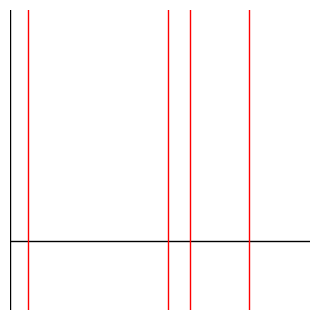

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Set your root values
A_inv, b, c, d = 15, 134, 153, 203


# Define a continuous range of x values
x = np.linspace(0, 255, 1000)

# Define the polynomial function
f = (x - A_inv) * (x - b) * (x - c) * (x - d)

# Set up the figure size to match image aspect ratio (e.g., 1:1 for 255x255)
fig, ax = plt.subplots(figsize=(3, 3), dpi=100)  # 300x300 pixels

# Plot the function
ax.plot(x, f, color='royalblue', linewidth=0)  # Make the curve 1px wide

# Draw thin x and y axes
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Draw vertical red lines for the roots
for root in [A_inv, b, c, d]:
    ax.axvline(root, color='red', linewidth=1)

# Tighten layout and remove all padding, ticks, spines
ax.set_xlim(0, 255)
ax.set_ylim(np.min(f), np.max(f))
ax.axis('off')

# Remove all margins and padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save the figure with tight bounding box
plt.savefig('polynomial_plot.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


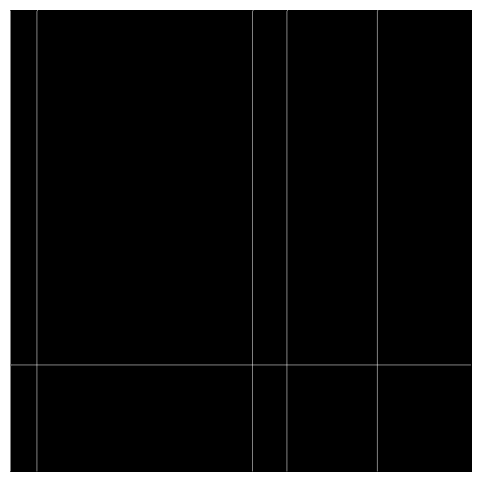

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (grayscale for processing)
img = cv2.imread("polynomial_plot.png", cv2.IMREAD_GRAYSCALE)

# Invert image so that the blue curve becomes white (for easy contour detection)
img_inverted = cv2.bitwise_not(img)

# Optional: apply Gaussian blur to remove noise
blurred = cv2.GaussianBlur(img_inverted, (3, 3), 0)

# Threshold the image to get binary curve
_, binary = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)

from skimage.morphology import skeletonize
from skimage.util import invert

# Convert binary to boolean for skeletonize (white=1, black=0)
binary_bool = binary > 0

# Skeletonize to get pixel-wide lines
skeleton = skeletonize(binary_bool)

# Convert back to uint8 image
skeleton_img = (skeleton * 255).astype(np.uint8)

# Show thinned image
plt.figure(figsize=(6, 6))
plt.imshow(skeleton_img, cmap='gray')
plt.axis('off')

# Save the image without any padding or white borders
plt.savefig('skeletonized_plot.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


Horizontal Line Y-coordinate: 1064
Intersection X-coordinates: [2, 80, 727, 830, 1101]


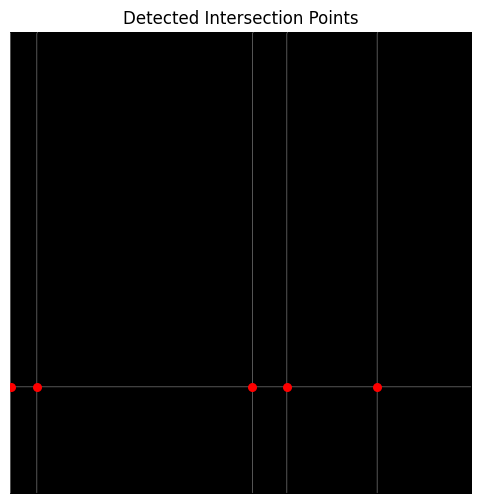

In [57]:
def detect_horizontal_intersections(skeleton_img, threshold=50):
    """
    Detect horizontal intersections in a skeletonized image.

    Parameters:
        skeleton_img (numpy.ndarray): The skeletonized image with 1-pixel wide lines.
        threshold (int): Minimum number of white pixels in a row to consider it a horizontal line.

    Returns:
        tuple: (horizontal_y, intersection_xs)
            - horizontal_y: The y-coordinate of the detected horizontal line.
            - intersection_xs: List of x-coordinates of vertical intersections.
    """
    # Step 1: Find y-coordinate of horizontal line
    row_sums = np.sum(skeleton_img == 255, axis=1)
    candidates = np.where(row_sums > threshold)[0]
    horizontal_y = candidates[np.argmax(row_sums[candidates])]

    # Step 2: Traverse that row, look for vertical intersections
    def is_vertical_intersection(y, x, img):
        return (
            img[y, x] == 255 and
            img[y-1:y+2, x].sum() >= 3 * 255  # enough white pixels vertically
        )

    intersection_xs = [x for x in range(1, skeleton_img.shape[1] - 1)
                       if is_vertical_intersection(horizontal_y, x, skeleton_img)]

    return horizontal_y, intersection_xs


def plot_intersections(skeleton_img, horizontal_y, intersection_xs):
    """
    Plot the detected intersections on the skeletonized image.

    Parameters:
        skeleton_img (numpy.ndarray): The skeletonized image.
        horizontal_y (int): The y-coordinate of the detected horizontal line.
        intersection_xs (list): List of x-coordinates of vertical intersections.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(skeleton_img, cmap='gray')
    for x in intersection_xs:
        plt.scatter(x, horizontal_y, color='red', s=30)
    plt.title("Detected Intersection Points")
    plt.axis('off')
    plt.show()


# Detect horizontal intersections
horizontal_y, intersection_xs = detect_horizontal_intersections(skeleton_img)
print(f"Horizontal Line Y-coordinate: {horizontal_y}")
print(f"Intersection X-coordinates: {intersection_xs}")
# Plot the detected intersections
plot_intersections(skeleton_img, horizontal_y, intersection_xs)


In [65]:
print("Original points: ", A_inv, b, c, d)

# Step 1: Find start and end x-coordinates of the horizontal line
horizontal_line = skeleton_img[horizontal_y]
# Get white pixel indices for the horizontal line
white_xs = np.where(skeleton_img[horizontal_y] == 255)[0]

# Find continuous segments (optional for better precision)
start_x = white_xs[0]
end_x = white_xs[-1]
line_length_pixels = end_x - start_x + 1

print(f"Start x: {start_x}, End x: {end_x}, Length in pixels: {line_length_pixels}")

# Step 2: Scale intersection x-coordinates to range 0–255
scaled_intersections = []
for x in intersection_xs:
    dist_from_start = x - start_x
    scaled_x = (dist_from_start / line_length_pixels) * 255
    scaled_intersections.append(scaled_x)

# Step 3: Print or use these scaled values as root approximations
print("Scaled root positions (0 to 255 scale):")
for i, sx in enumerate(scaled_intersections[1:]):
    # rounded up to the next integer
    print(f"Root {i+1}: {int(np.ceil(sx))}")


Original points:  15 134 153 203
Start x: 2, End x: 1382, Length in pixels: 1381
Scaled root positions (0 to 255 scale):
Root 1: 15
Root 2: 134
Root 3: 153
Root 4: 203


In [61]:
import cryptosteganography
from cryptosteganography import CryptoSteganography
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import io

# Load the skeletonized image
# Paths
cover_image_path = "cover_image.jpg"
secret_image_path = "skeletonized_plot.png"
output_stego_image_path = "stego_image.png"
password = "my_secret_key"

# Load the cover image
cover = Image.open(cover_image_path)

# Load the secret image and convert to bytes
secret = Image.open(secret_image_path)
secret_bytes_io = io.BytesIO()
# compress the image to reduce size
secret.save(secret_bytes_io, format='PNG', optimize=True)
secret_bytes = secret_bytes_io.getvalue()
# Convert bytes to numpy array
secret_array = np.frombuffer(secret_bytes, dtype=np.uint8)
# Get the size of the secret image
secret_size = secret_array.size
print(f"Secret image size: {secret_size} bytes")
# Check if the cover image can hold the secret image
cover_size = cover.size[0] * cover.size[1] * 3  # RGB image
print(f"Cover image size: {cover_size} bytes")
if secret_size > cover_size:
    raise ValueError("Secret image is too large to hide in the cover image.")


# Hide the secret image bytes into the cover image
crypto_steg = CryptoSteganography(password)
crypto_steg.hide(cover_image_path, output_stego_image_path, secret_bytes)

print("✅ Secret image hidden successfully in stego image.")

Secret image size: 11482 bytes
Cover image size: 196608 bytes
✅ Secret image hidden successfully in stego image.


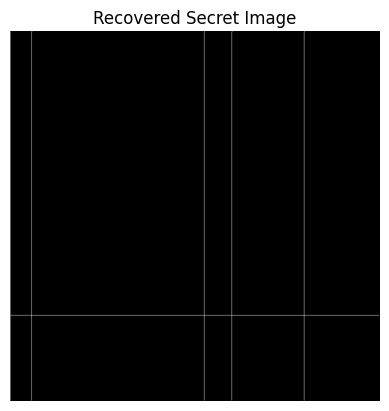

✅ Secret image recovered successfully.


In [62]:
stego_image_path = "stego_image.png"
password = "my_secret_key"
recovered_secret_image_path = "recovered_secret.png"

# Initialize CryptoSteganography with the same password
crypto_steg = CryptoSteganography(password)

# Retrieve the hidden data (this returns the bytes you originally hid)
recovered_bytes = crypto_steg.retrieve(stego_image_path)

# Check if any data was retrieved
if recovered_bytes is None:
    raise ValueError("No hidden data found or incorrect password.")

# Convert bytes back into an image
secret_image_io = io.BytesIO(recovered_bytes)
secret_image = Image.open(secret_image_io)

# Optional: Save the recovered image
secret_image.save(recovered_secret_image_path)

# plot the recovered image
plt.imshow(secret_image, cmap='gray')
plt.axis('off')
plt.title('Recovered Secret Image')
plt.show()

print("✅ Secret image recovered successfully.")


Horizontal Line Y-coordinate: 1064
Intersection X-coordinates: [2, 80, 727, 830, 1101]


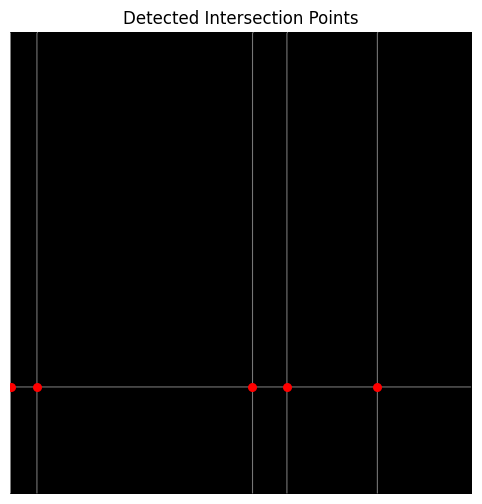

In [63]:
# Get intersection points from this recovered image recovered_secret.png
# Load the recovered secret image
secret_image = Image.open(recovered_secret_image_path).convert('L')
secret_image = np.array(secret_image).astype(np.int64)
# Convert to binary image
secret_image_binary = secret_image > 0
# Skeletonize the binary image
skeleton_img = skeletonize(secret_image_binary)

# save the skeletonized image as is without any processing or plotting
skeleton_img_path = "skeletonized_recovered_secret.png"
skeleton_img = (skeleton_img * 255).astype(np.uint8)
cv2.imwrite(skeleton_img_path, skeleton_img)



# Detect horizontal intersections
horizontal_y, intersection_xs = detect_horizontal_intersections(skeleton_img)
print(f"Horizontal Line Y-coordinate: {horizontal_y}")
print(f"Intersection X-coordinates: {intersection_xs}")
# Plot the detected intersections
plot_intersections(np.array(secret_image), horizontal_y, intersection_xs)

In [70]:
print("Original points: ", A_inv, b, c, d)

# Step 1: Find start and end x-coordinates of the horizontal line
horizontal_line = skeleton_img[horizontal_y]
# Get white pixel indices for the horizontal line
white_xs = np.where(skeleton_img[horizontal_y] == 255)[0]

# Find continuous segments (optional for better precision)
start_x = white_xs[0]
end_x = white_xs[-1]
line_length_pixels = end_x - start_x + 1

print(f"Start x: {start_x}, End x: {end_x}, Length in pixels: {line_length_pixels}")

# Step 2: Scale intersection x-coordinates to range 0–255
scaled_intersections = []
for x in intersection_xs:
    dist_from_start = x - start_x
    scaled_x = (dist_from_start / line_length_pixels) * 255
    scaled_intersections.append(scaled_x)

# Step 3: Print or use these scaled values as root approximations
print("Scaled root positions (0 to 255 scale):")
roots = []
for i, sx in enumerate(scaled_intersections[1:]):
    # rounded to the next integer
    roots.append(int(np.ceil(sx)))
    print(f"Root {i+1}: {int(np.ceil(sx))}")

Original points:  15 134 153 203
Start x: 2, End x: 1382, Length in pixels: 1381
Scaled root positions (0 to 255 scale):
Root 1: 15
Root 2: 134
Root 3: 153
Root 4: 203


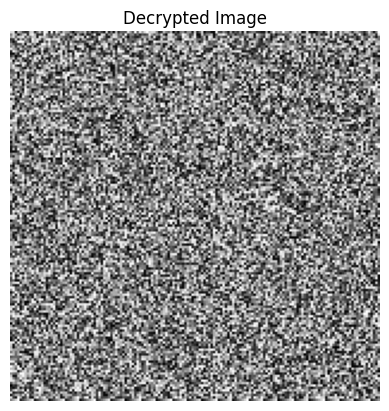

Decrypted Image Size: 192200 bytes
Decrypted Image Shape: (155, 155)
PSNR: 344.8822838568607
SSIM: -0.0032718839618165823


In [71]:
# use these roots for decryption
# Decrypt the image using the inverse randomizer equation
decrypted_image = np.zeros_like(encrypted_image, dtype=np.uint64)
for i in range(encrypted_image.shape[0]):
    for j in range(encrypted_image.shape[1]):
        decrypted_image[i, j] = inverse_randomizer(encrypted_image[i, j], roots[0], roots[1], roots[2], roots[3], i, j, N)



# Convert back to an image
# new_image_decrypted = Image.fromarray(decrypted_image.astype(np.uint64))

# Plotting decrypted image
plt.imshow(decrypted_image, cmap='gray')
plt.axis('off')
plt.title('Decrypted Image')
plt.show()
# Size and Shape of decrypted image
print(f"Decrypted Image Size: {decrypted_image.nbytes} bytes")
print(f"Decrypted Image Shape: {decrypted_image.shape}")
psnr_value = psnr(new_image, decrypted_image)
ssim_value = ssim(new_image, decrypted_image, data_range=decrypted_image.max() - decrypted_image.min())
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")


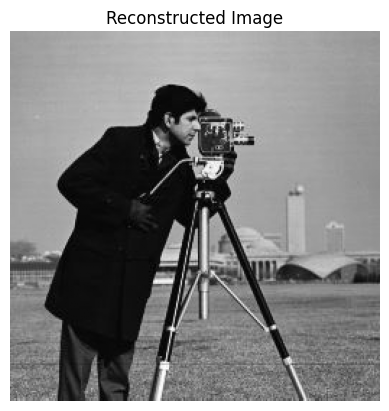

In [73]:
# now undo the huffman encoding
decoded_pixels = huffman_decode(encoded_bits, code_map)
# undoing the difference matrix
reconstructed_diff_img = inverse_difference(np.array(decoded_pixels).reshape(image.shape))
plt.imshow(reconstructed_diff_img, cmap='gray')
plt.axis('off')
plt.title('Reconstructed Image')
plt.show()